# Visualize SAIL data

In [21]:
# Import packages
from soslib import funcs
import act
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timezone
import pytz
import seaborn as sns
import glob


### Open SPLASH data

In [40]:
all_files = glob.glob('../data/roaring_judy/NOAA_PSL_SurfaceMeteorology_RoaringJudy/*')
li = []
cols = [
    "Datalogger ID",
"Year",
"Julian Day",
"HoursMinutes",
"Pressure (mb)",
"Temperature (C)",
"Relative Humidity (%)",
"Scalar Wind Speed (m/s)",
"Vector Wind Speed (m/s)",
"Wind Direction (degrees)",
"Wind Direction Standard Deviation (degrees)",
"Battery Voltage (volts)",
"Maximum Wind Speed (m/s)",
]
for filename in all_files:
    df = pd.read_csv(filename, header=None, names=cols)
    df['HoursMinutes'] = df['HoursMinutes'].astype(str)
    # add leading zero if length is 3
    df['HoursMinutes'] = df['HoursMinutes'].apply(lambda x: x.zfill(4))
    # split the last two digits
    df['Hours'] = df['HoursMinutes'].str[:-2]
    df['Minutes'] = df['HoursMinutes'].str[-2:]
    # convert year and julian day to datetime
    df['Year'] = df['Year'].astype(str)
    df['Julian Day'] = df['Julian Day'].astype(str)
    df['Julian Day'] = df['Year'] + '-' + df['Julian Day'] + ' ' + df['Hours'] + ':' + df['Minutes']
    df['Date'] = pd.to_datetime(df['Julian Day'], format='%Y-%j %H:%M')
    # drop Julian Day and HoursMinutes, Year, Hours, Minutes
    df = df.drop(columns=['Julian Day', 'HoursMinutes', 'Year', 'Hours', 'Minutes'])
    li.append(df)



In [41]:
all_df = pd.concat(li,axis=0)


In [43]:
all_df = all_df.set_index('Date', drop=True)

In [45]:
# add UTC timezone
all_df.index = all_df.index.tz_localize('UTC')
# convert to mountain time
all_df.index = all_df.index.tz_convert('US/Mountain')

In [307]:
all_df['u'] = -all_df['Scalar Wind Speed (m/s)'] * np.sin(np.deg2rad(all_df['Wind Direction (degrees)']))
all_df['v'] = -all_df['Scalar Wind Speed (m/s)'] * np.cos(np.deg2rad(all_df['Wind Direction (degrees)']))

In [308]:
# Iterate to create the dataframe for plotting
tmp = []
idx = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
for month in all_df.index.month.unique():
    a = all_df[all_df.index.month == month]
    u = a.u.groupby(a.index.hour).mean()
    v = a.v.groupby(a.index.hour).mean()
    dir = pd.Series(np.rad2deg(np.arctan2(-u,-v)))
    # if dir is negative, add 360
    dir[dir<0] = dir[dir<0] + 360
    # if dir is greater than 360, subtract 360
    dir[dir>360] = dir[dir>360] - 360
    dir.name=month
    tmp.append(dir)
    # a = a.groupby(a.index.hour).median()
    # a.name=month
    # tmp.append(a)
roaring_judy_hourly = pd.concat(tmp, axis=1).T
roaring_judy_hourly = roaring_judy_hourly.sort_index()

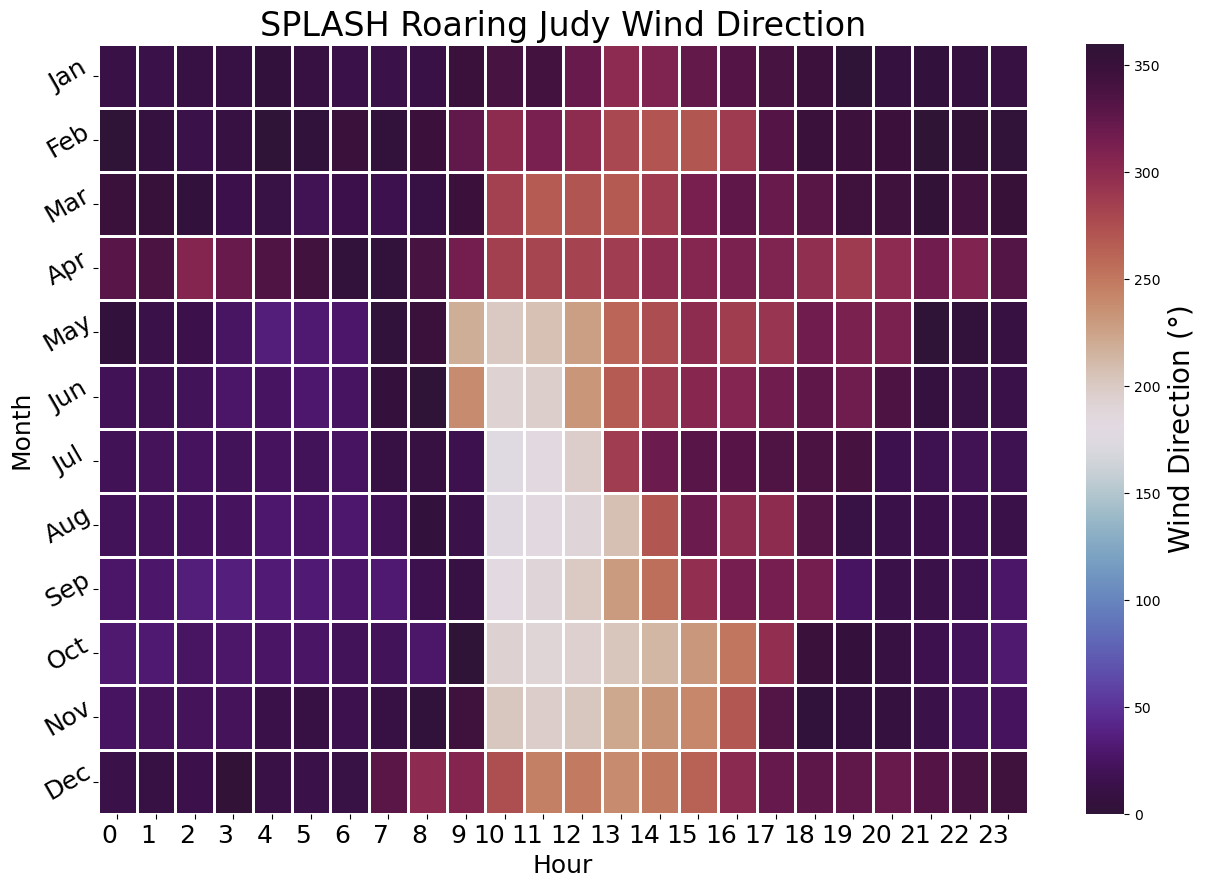

In [309]:

fig, ax=plt.subplots(figsize=(15,10), facecolor='w')

# months = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
sns.heatmap(roaring_judy_hourly, cmap='twilight_shifted', vmin=0, vmax=360,linewidths=2, cbar_kws={'label':'Wind Direction ($\degree$)'}, ax=ax)
ax.set_xticklabels(roaring_judy_hourly.columns, rotation=0, ha='right', size=18);
ax.set_yticklabels(months, rotation=30, ha='center', size=18);
ax.tick_params(axis='y', which='major', pad=18)
ax.set_xlabel('Hour',size=18)
ax.set_ylabel('Month', size=18)
ax.set_title('SPLASH Roaring Judy Wind Direction', size=24)
ax.figure.axes[-1].yaxis.label.set_size(20)

In [61]:
def met_data_formatting(ckp_df):
    """Formatting for radsys data"""
    # Convert DateTime column to datetime
    ckp_df['time'] = pd.to_datetime(ckp_df['time'], format='%Y %m %d %H %M')
    # Add column numbers
    col_num = [1,2,3,4,5,6,7,8,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51]
    col_num = [num - 1 for num in col_num]
    col_names = ["yyyy","jday","month","day","hour","min","dt","SZA","dw_solar","uw_solar","Direct horizontal","Diffuse",
                "dw_ir","DwCaseTemp","DwDomeTemp","uw_ir","UwCaseTemp","UwDomeTemp","UVB","PAR","NetSolar","NetIR",
                "TotalNet","AirTemp","RH","WindSpd","WindDir","Baro","SPN1_total_Avg","SPN1_diffuse_Avg"]
    ckp_df = ckp_df.rename(columns = dict(zip(col_num, col_names))) 
    # Create QC column names
    qc_col_numbers = ckp_df.columns[5::2]
    new_qc_names = [f'{col_name}_qc' for col_name in ckp_df.columns[4::2]]
    ckp_df = ckp_df.rename(columns = dict(zip(qc_col_numbers,new_qc_names)))

    ckp_ds = ckp_df.set_index('time', drop=True).to_xarray()
    return ckp_ds


In [59]:
attributes_dict = {"SZA":
{"value":"solar zenith angle",
"units":"Degrees",
"type":"Float",
"QC":"Calc From Timestamp and Lat/Lon"},
"dw_solar":
{"value":"downwelling global solar",
"units":"W/m^2",
"type":"Float",
"QC":"QC = Col 10"},
"uw_solar":
{"value":"upwelling global solar",
"units":"W/m^2",
"type":"Float",
"QC":"QC = Col 12"},
"Direct horizontal":
{"value":"Direct horizontal solar",
"units":"W/m^2",
"type":"Float",
"QC":"QC = Col 14, calculated as described below"},
"Diffuse":
{"value":"Downwelling diffuse solar",
"units":"W/m^2",
"type":"Float",
"QC":"QC = Col 16, calculated as described below"},
"dw_ir":
{"value":"downwelling thermal infrared",
"units":"W/m^2",
"type":"Float",
"QC":"QC = Col 18"},
"DwCaseTemp":
{"value":"downwelling IR case temp.",
"units":"Kelvin",
"type":"Float",
"QC":"QC = Col 20"},
"DwDomeTemp":
{"value":"downwelling IR dome temp.",
"units":"Kelvin",
"type":"Float",
"QC":"QC = Col 22"},
"uw_ir":
{"value":"upwelling thermal infrared",
"units":"W/m^2",
"type":"Float",
"QC":"QC = Col 24"},
"UwCaseTemp":
{"value":"upwelling IR case temp.",
"units":"Kelvin",
"type":"Float",
"QC":"QC = Col 26"},
"UwDomeTemp":
{"value":"upwelling IR dome temp.",
"units":"Kelvin",
"type":"Float",
"QC":"QC = Col 28"},
"UV":
{"value":"global UVB",
"units":"W/m^2",
"type":"Float",
"QC":"QC = Col 30, not usually measured with RADSYS"},
"PAR":
{"value":"photosynthetically active radiation",
"units":"W/m^2",
"type":"Float",
"QC":"QC = Col 32, not usually measured with RADSYS"},
"NetSolar":
{"value":"net solar (dw_solar - uw_solar)",
"units":"W/m^2",
"type":"Float",
"QC":"QC = Col 34"},
"NetIR":
{"value":"net infrared (dw_ir - uw_ir)",
"units":"W/m^2",
"type":"Float",
"QC":"QC = Col 36"},
"TotalNet":
{"value":"net radiation (netsolar+netir)",
"units":"W/m^2",
"type":"Float",
"QC":"QC = Col 38"},
"AirTemp":
{"value":"10-meter air temperature",
"units":"Celcius",
"type":"Float",
"QC":"QC = Col 40"},
"RH":
{"value":"relative humidity",
"units":"%",
"type":"Float",
"QC":"QC = Col 42"},
"WindSpd":
{"value":"wind speed",
"units":"m/s",
"type":"Float",
"QC":"QC = Col 44"},
"WindDir":
{"value":"wind direction",
"units":"Degrees",
"type":"Float",
"QC":"QC = Col 46"},
"Baro":
{"value":"station pressure",
"units":"mBar",
"type":"Float",
"QC":"QC = Col 48"},
"SPN1_total_Avg": 
{"value":"Total irradiance as measured by SPN1",
"units":"W/m^2",
"type":"Float",
"QC":"QC = Col 50"},
"SPN1_diffuse_Avg":
{"value":"Diffuse irradiance as measured by SPN1",
"units":"W/m^2",
"type":"Float",
"QC":"QC = Col 52"}}

### RADSYS data from Kettle Ponds

In [89]:
all_files = glob.glob('../data/ckp/*.dat')
datasets = []
for fn in all_files:
    try:
        ckp_df = pd.read_csv(fn, 
                            skiprows=2, 
                            header=None, 
                            delim_whitespace=True, 
                            parse_dates={'time':[0,2,3,4,5]}, 
                            date_format='%Y %m %d %H %M',)
        datasets.append(met_data_formatting(ckp_df))
    except:
        print(fn)
        continue
    # read in data
radsys_ds = xr.concat(datasets, dim='time')
radsys_ds.attrs.update({'QC_flag':'0 for good data, 1 for bad data, 2 for questionable data',
                    'no_data': -9999.9,
                    'time':'UTC',
                    'reported_data':'Reported data are 1 minute averages of 1 second samples, reported times are the end of the 1-min. averaging period',
                    'datastreamname':'Radsys'})
# add a coordinate with LocalTime for Plotting
time_utc = radsys_ds['time'].to_index().tz_localize(pytz.UTC)
us_mtn = pytz.timezone('US/Mountain')
tz_corrected = time_utc.tz_convert(us_mtn).tz_localize(None)
local_da=xr.DataArray.from_series(tz_corrected)
radsys_ds.coords.update({'local_time':tz_corrected})


    # with open('./radsys_attributes.txt', 'r') as j:
    #     attribute_dict = json.loads(j.read())
attributes = attributes_dict
for variable in radsys_ds.variables:
    if variable in attributes.keys():
        radsys_ds[variable].attrs.update(attributes[variable])

../data/ckp/ckp22199.dat
../data/ckp/ckp22262.dat
../data/ckp/ckp22311.dat
../data/ckp/ckp22363.dat
../data/ckp/ckp23110.dat
../data/ckp/ckp23124.dat
../data/ckp/ckp23127.dat
../data/ckp/ckp23152.dat
../data/ckp/ckp23153.dat
../data/ckp/ckp23170.dat
../data/ckp/ckp23171.dat
../data/ckp/ckp23187.dat
../data/ckp/ckp23194.dat


In [91]:
ckp_radsys_df = radsys_ds.to_dataframe().set_index('local_time')
# fill -9999.9 with NaN
ckp_radsys_df = ckp_radsys_df.replace(-9999.9, np.nan)

In [304]:
ckp_radsys_df['u'] = -ckp_radsys_df['WindSpd'] * np.sin(np.deg2rad(ckp_radsys_df['WindDir']))
ckp_radsys_df['v'] = -ckp_radsys_df['WindSpd'] * np.cos(np.deg2rad(ckp_radsys_df['WindDir']))

In [305]:
# Iterate to create the dataframe for plotting
tmp = []
idx = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
for month in ckp_radsys_df.index.month.unique():
    a = ckp_radsys_df[ckp_radsys_df.index.month == month]['WindDir']
    a = a.groupby(a.index.hour).median()
    a.name=month
    b = ckp_radsys_df[ckp_radsys_df.index.month == month]
    u = b.u.groupby(b.index.hour).mean()
    v = b.v.groupby(b.index.hour).mean()
    dir = pd.Series(270-np.rad2deg(np.arctan2(v,u)))
    # if dir is negative, add 360
    dir[dir<0] = dir[dir<0] + 360
    # if dir is greater than 360, subtract 360
    dir[dir>360] = dir[dir>360] - 360
    dir.name=month
    tmp.append(dir)
kettle_ponds_hourly = pd.concat(tmp, axis=1).T
kettle_ponds_hourly = kettle_ponds_hourly.sort_index()

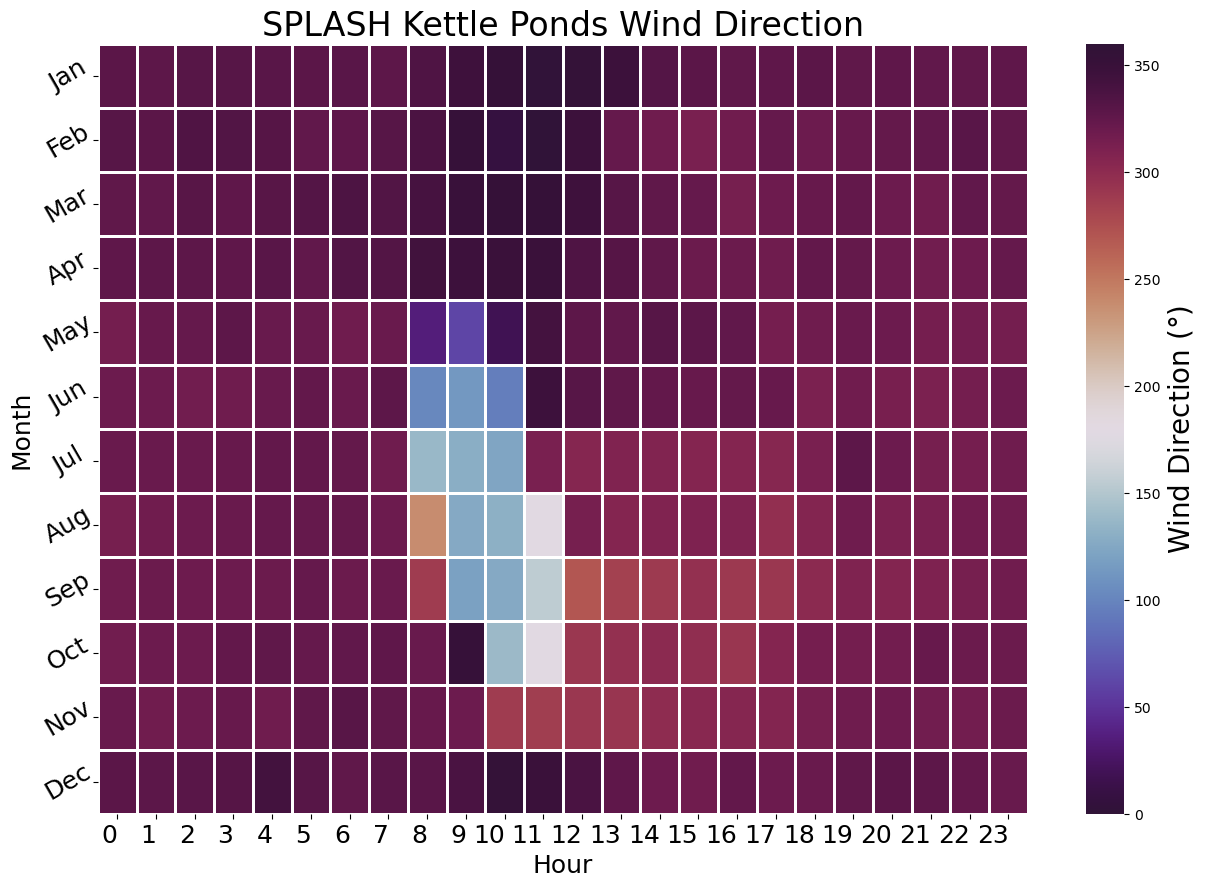

In [306]:

fig, ax=plt.subplots(figsize=(15,10), facecolor='w')

# months = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
sns.heatmap(kettle_ponds_hourly, cmap='twilight_shifted', vmin=0, vmax=360,linewidths=2, cbar_kws={'label':'Wind Direction ($\degree$)'}, ax=ax)
ax.set_xticklabels(kettle_ponds_hourly.columns, rotation=0, ha='right', size=18);
ax.set_yticklabels(months, rotation=30, ha='center', size=18);
ax.tick_params(axis='y', which='major', pad=18)
ax.set_xlabel('Hour',size=18)
ax.set_ylabel('Month', size=18)
ax.set_title('SPLASH Kettle Ponds Wind Direction', size=24)
ax.figure.axes[-1].yaxis.label.set_size(20)

### RADSYS data from Brush Creek

In [79]:
all_files = glob.glob('../data/cbc/*.dat')
datasets = []
for fn in all_files:
    try:
        ckp_df = pd.read_csv(fn, 
                            skiprows=2, 
                            header=None, 
                            delim_whitespace=True, 
                            parse_dates={'time':[0,2,3,4,5]}, 
                            date_format='%Y %m %d %H %M',)
        datasets.append(met_data_formatting(ckp_df))
    except:
        print(fn)
        continue
    # read in data
radsys_ds = xr.concat(datasets, dim='time')
radsys_ds.attrs.update({'QC_flag':'0 for good data, 1 for bad data, 2 for questionable data',
                    'no_data': -9999.9,
                    'time':'UTC',
                    'reported_data':'Reported data are 1 minute averages of 1 second samples, reported times are the end of the 1-min. averaging period',
                    'datastreamname':'Radsys'})
# add a coordinate with LocalTime for Plotting
time_utc = radsys_ds['time'].to_index().tz_localize(pytz.UTC)
us_mtn = pytz.timezone('US/Mountain')
tz_corrected = time_utc.tz_convert(us_mtn).tz_localize(None)
local_da=xr.DataArray.from_series(tz_corrected)
radsys_ds.coords.update({'local_time':tz_corrected})


    # with open('./radsys_attributes.txt', 'r') as j:
    #     attribute_dict = json.loads(j.read())
attributes = attributes_dict
for variable in radsys_ds.variables:
    if variable in attributes.keys():
        radsys_ds[variable].attrs.update(attributes[variable])

../data/cbc/cbc22199.dat
../data/cbc/cbc22262.dat
../data/cbc/cbc22311.dat
../data/cbc/cbc22363.dat
../data/cbc/cbc23110.dat
../data/cbc/cbc23124.dat
../data/cbc/cbc23127.dat
../data/cbc/cbc23152.dat
../data/cbc/cbc23153.dat
../data/cbc/cbc23170.dat
../data/cbc/cbc23171.dat
../data/cbc/cbc23187.dat
../data/cbc/cbc23194.dat


In [82]:
cbc_radsys_df = radsys_ds.to_dataframe().set_index('local_time')
# fill -9999.9 with NaN
cbc_radsys_df = cbc_radsys_df.replace(-9999.9, np.nan)

In [310]:
cbc_radsys_df['u'] = -cbc_radsys_df['WindSpd'] * np.sin(np.deg2rad(cbc_radsys_df['WindDir']))
cbc_radsys_df['v'] = -cbc_radsys_df['WindSpd'] * np.cos(np.deg2rad(cbc_radsys_df['WindDir']))

In [311]:
# Iterate to create the dataframe for plotting
tmp = []
idx = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
for month in cbc_radsys_df.index.month.unique():
    a = cbc_radsys_df[cbc_radsys_df.index.month == month]['WindDir']
    a = a.groupby(a.index.hour).median()
    a.name=month
    b = cbc_radsys_df[cbc_radsys_df.index.month == month]
    u = b.u.groupby(b.index.hour).mean()
    v = b.v.groupby(b.index.hour).mean()
    dir = pd.Series(270-np.rad2deg(np.arctan2(v,u)))
    # if dir is negative, add 360
    dir[dir<0] = dir[dir<0] + 360
    # if dir is greater than 360, subtract 360
    dir[dir>360] = dir[dir>360] - 360
    dir.name=month
    tmp.append(dir)
brush_creek_hourly = pd.concat(tmp, axis=1).T
brush_creek_hourly = brush_creek_hourly.sort_index()

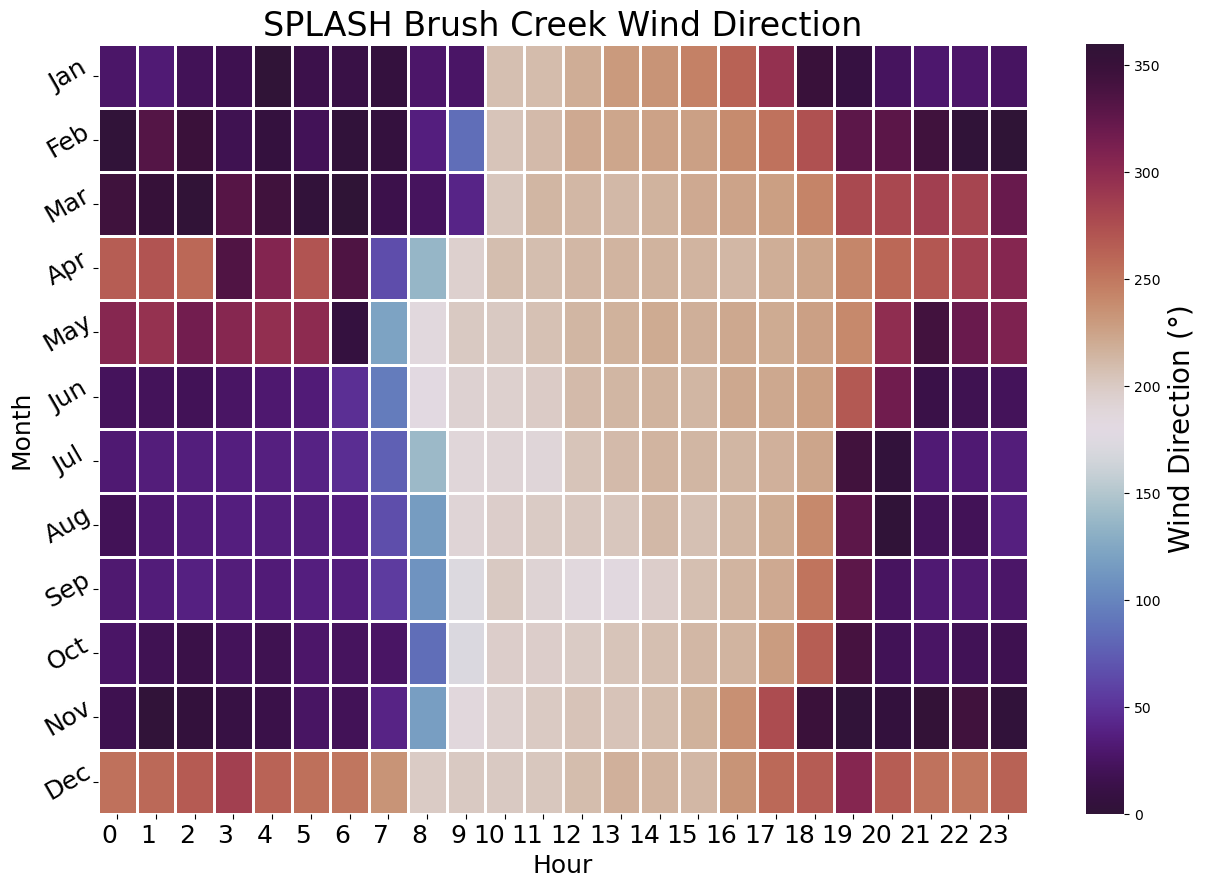

In [312]:

fig, ax=plt.subplots(figsize=(15,10), facecolor='w')

# months = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
sns.heatmap(brush_creek_hourly, cmap='twilight_shifted', vmin=0, vmax=360,linewidths=2, cbar_kws={'label':'Wind Direction ($\degree$)'}, ax=ax)
ax.set_xticklabels(brush_creek_hourly.columns, rotation=0, ha='right', size=18);
ax.set_yticklabels(months, rotation=30, ha='center', size=18);
ax.tick_params(axis='y', which='major', pad=18)
ax.set_xlabel('Hour',size=18)
ax.set_ylabel('Month', size=18)
ax.set_title('SPLASH Brush Creek Wind Direction', size=24)
ax.figure.axes[-1].yaxis.label.set_size(20)

# Download necessary ECOR, CEIL, and SEBS data

In [248]:
# User and token for pulling in data
new_user=False
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")

ecor_kp = 'guc30ecorS3.b1'
met_ds = 'gucmetM1.b1'
sebs = 'gucsebsS3.b1'
ld = 'gucldM1.b1'
start = '2021-10-01'
end = '2022-09-30' 

if new_user:
    # ecor_ds = funcs.get_sail_data(username,token,ecor_kp,start,end, output='/storage/dlhogan/SAIL/SAIL_ecor_kp_wy2022.nc')
    met_ds = funcs.get_sail_data(username,token,met_ds,start,end, output='/storage/dlhogan/SAIL/SAIL_met_gts_wy2022.nc')
    sebs_ds = funcs.get_sail_data(username,token,sebs,start,end, output='/storage/dlhogan/SAIL/SAIL_sebs_gts_wy2022.nc')

else:
    # If this was already downloaded, we just need to access the files
    ecor_22_ds = xr.open_dataset('/storage/dlhogan/synoptic_sublimation/sail_data/winter_21_22/eddy_covariance_kettle_ponds_20211001_20220930.nc')
    # ecor_23_ds = xr.open_dataset('/storage/dlhogan/synoptic_sublimation/sail_data/winter_22_23/eddy_covariance_kettle_ponds_20221001_20230930.nc')
    met_22_ds = xr.open_dataset('/storage/dlhogan/synoptic_sublimation/sail_data/winter_21_22/met_20211001_20220930.nc')
    met_23_ds = xr.open_dataset('/storage/dlhogan/synoptic_sublimation/sail_data/winter_22_23/met_20221001_20230930.nc')
    # sebs_ds = xr.open_dataset('/storage/dlhogan/sos/data/ncdfs/sebs_kp.nc')
    # ls_ds_00 = xr.open_dataset('/storage/dlhogan/sos/data/laser_distrometer/ld_00.nc')
    # ls_ds_01 = xr.open_dataset('/storage/dlhogan/sos/data/laser_distrometer/ld_01.nc')
    # ls_ds_02 = xr.open_dataset('/storage/dlhogan/sos/data/laser_distrometer/ld_02.nc')
    # ls_ds_03 = xr.open_dataset('/storage/dlhogan/sos/data/laser_distrometer/ld_03.nc')
    # ls_ds_04 = xr.open_dataset('/storage/dlhogan/sos/data/laser_distrometer/ld_04.nc')

In [249]:
met_ds = xr.concat([met_22_ds,met_23_ds],dim='time')

In [225]:
def add_local_time(ds):
    time_utc = ds['time'].to_index().tz_localize(pytz.UTC)
    us_mtn = pytz.timezone('US/Mountain')
    tz_corrected = time_utc.tz_convert(us_mtn).tz_localize(None)
    local_da=xr.DataArray.from_series(tz_corrected)
    ds.coords.update({'local_time':tz_corrected})
    return ds

In [226]:
# Quick check on how much ecor data we are missing by month
((met_ds['wdir_vec_mean'].isnull().groupby(met_ds.time.dt.month).sum()/met_ds['wdir_vec_mean'].isnull().groupby(met_ds.time.dt.month).count())*100).values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [318]:
met_ds['u'] = -met_ds['wspd_vec_mean'] * np.sin(np.deg2rad(met_ds['wdir_vec_mean']))
met_ds['v'] = -met_ds['wspd_vec_mean'] * np.cos(np.deg2rad(met_ds['wdir_vec_mean']))

In [319]:
# add local time and create dataframe
met_df = add_local_time(met_ds[['wdir_vec_mean', 'u','v']]).to_dataframe()
# sebs_df = add_local_time(sebs_ds['down_short_hemisp'].where(sebs_ds['qc_down_short_hemisp']==0)).to_dataframe()
met_df = met_df.set_index('local_time')
# sebs_df = sebs_df.set_index('local_time')

In [320]:
# Iterate to create the dataframe for plotting
tmp = []
idx = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
for month in met_df.index.month.unique():
    a = met_df[met_df.index.month == month]
    b = met_df[met_df.index.month == month]['wdir_vec_mean']
    u = a.u.groupby(a.index.hour).mean()
    v = a.v.groupby(a.index.hour).mean()
    b = b.groupby(b.index.hour).median()
    b[b<0] = b[b<0] + 360
    b[b>360] = b[b>360] - 360
    dir = pd.Series(270-np.rad2deg(np.arctan2(v,u)))
    # if dir is negative, add 360
    dir[dir<0] = dir[dir<0] + 360
    # if dir is greater than 360, subtract 360
    dir[dir>360] = dir[dir>360] - 360
    dir.name=month
    b.name=month
    tmp.append(dir)
met_df_hourly = pd.concat(tmp, axis=1).T

# tmp=[]
# for month in sebs_df.index.month.unique():
#     a = sebs_df[sebs_df.index.month == month]['down_short_hemisp']
#     a = a.groupby(a.index.hour).mean()
#     a.name=month
#     tmp.append(a)
# sebs_ds_hourly = pd.concat(tmp, axis=1).T

In [321]:
# Sort for plotting
# sebs_ds_hourly = sebs_ds_hourly.fillna(0).sort_index()
met_ds_hourly = met_df_hourly.sort_index()
met_ds_hourly

local_time,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
1,9.035889,9.170715,14.338257,17.345825,18.512024,17.287567,16.180298,17.730347,5.084290,344.753113,...,334.467010,336.403748,346.324829,6.219360,4.878845,3.649658,10.158783,13.166046,11.368561,10.870422
2,17.064758,21.740204,24.828918,22.846436,22.266235,25.648010,31.427734,27.514221,13.872192,358.288727,...,323.087128,331.435852,341.760071,352.748383,358.683167,10.266510,15.546967,22.865204,15.386719,25.962738
3,13.925751,16.119324,14.519775,17.412170,16.174988,19.010376,15.720398,15.158997,9.248840,346.580078,...,320.321960,325.450317,325.560608,334.539368,350.240173,359.080994,2.946960,5.888916,7.138428,15.346161
4,17.074097,17.863556,14.997681,11.385193,8.648010,12.534119,13.960022,6.801514,4.898529,350.907867,...,339.960663,338.719177,337.146698,344.061920,353.623627,6.321350,13.599854,7.625732,10.882538,7.179321
5,24.426361,21.968536,19.165771,19.494202,18.429321,18.255432,358.826050,4.244507,347.394897,348.342712,...,343.533020,347.046265,345.550690,338.517670,356.812408,2.919006,23.395416,25.923096,23.058594,17.996643
6,0.604492,1.202148,358.936462,359.702148,4.242523,5.916809,0.049652,355.945679,249.244247,168.660934,...,348.945862,346.361786,348.003693,332.654144,330.560791,353.812408,8.080688,5.690125,9.991638,6.051025
7,5.069946,1.077576,357.242554,4.248962,359.765350,5.141296,2.473938,1.486816,280.163025,203.516510,...,337.454315,324.179077,339.525238,345.652588,352.384674,36.986389,18.091339,13.926147,1.687134,0.413116
8,6.716858,1.551849,359.439178,358.927185,1.369537,1.718811,1.141541,5.856689,341.393982,208.734360,...,327.600098,328.845642,327.786682,329.597992,0.103088,9.352753,12.488220,1.235229,13.334198,3.870789
9,2.631500,4.928467,4.698975,6.456635,7.403656,8.123810,7.906036,10.721954,14.917816,321.783295,...,328.962830,323.092255,318.357605,328.907745,345.220215,353.751923,0.871307,2.943237,4.663147,8.292786
10,2.693542,9.260376,12.467041,331.542419,18.853210,13.274567,14.121094,20.093475,20.274353,24.392914,...,324.512146,323.535004,325.465393,344.667053,354.063019,4.723236,5.119232,1.718567,5.067078,5.611694


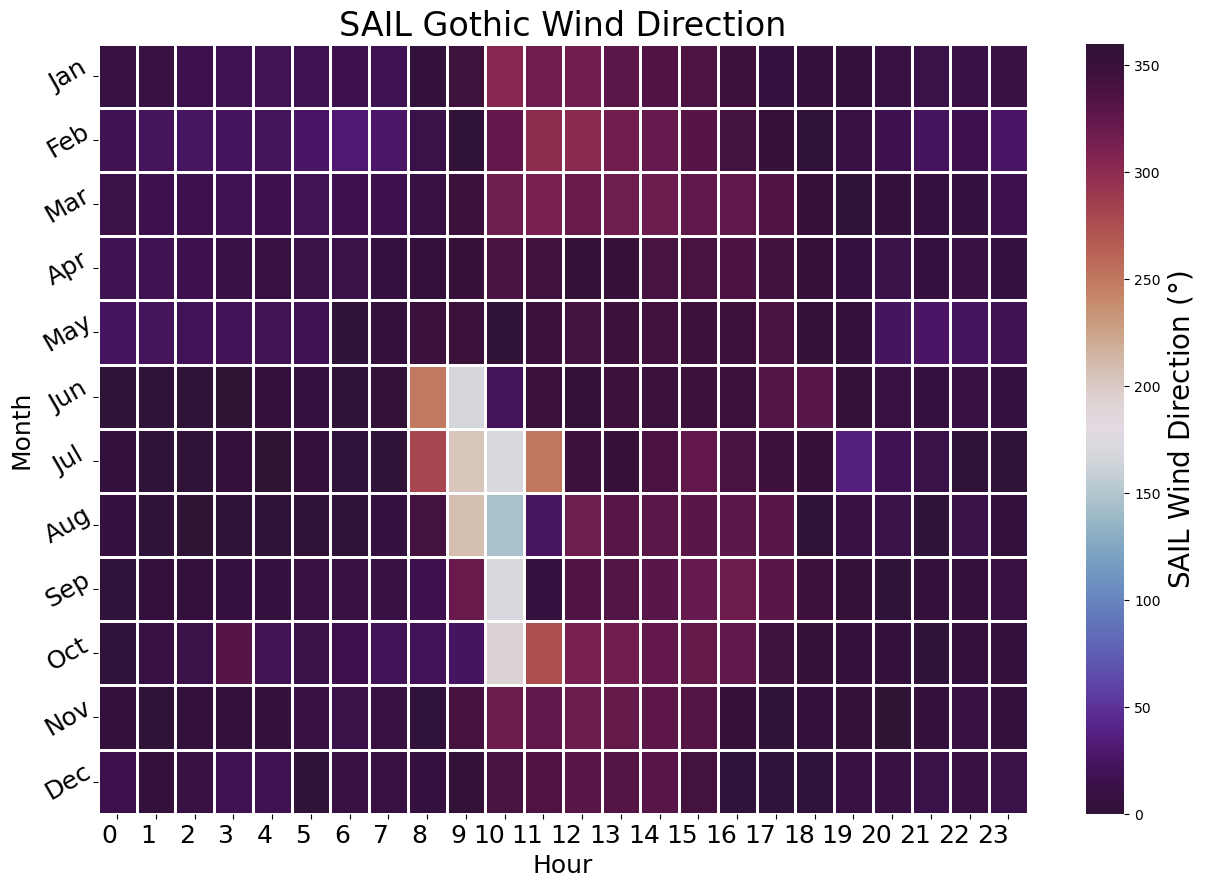

In [322]:

fig, ax=plt.subplots(figsize=(15,10), facecolor='w')

# months = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
sns.heatmap(met_ds_hourly, cmap='twilight_shifted', vmin=0, vmax=360,linewidths=2, cbar_kws={'label':'SAIL Wind Direction ($\degree$)'}, ax=ax)
ax.set_xticklabels(met_ds_hourly.columns, rotation=0, ha='right', size=18);
ax.set_yticklabels(months, rotation=30, ha='center', size=18);
ax.tick_params(axis='y', which='major', pad=18)
ax.set_xlabel('Hour',size=18)
ax.set_ylabel('Month', size=18)
ax.set_title('SAIL Gothic Wind Direction', size=24)
ax.figure.axes[-1].yaxis.label.set_size(20)

# sns.heatmap(sebs_ds_hourly, cmap='hot',linewidths=2, cbar_kws={'label':'SAIL SW Radiation (W/m$^2$)'}, ax=axs[1])
# axs[1].set_xticklabels(sebs_ds_hourly.columns, rotation=0, ha='right', size=18);
# axs[1].set_yticklabels(months, rotation=30, ha='center', size=18);
# axs[1].tick_params(axis='y', which='major', pad=18)
# axs[1].set_xlabel('Hour',size=18)
# axs[1].set_ylabel('Month', size=18)
# axs[1].set_title('SAIL Kettle Ponds DW Radiation', size=24)
# axs[1].figure.axes[-1].yaxis.label.set_size(20)

### Plot Ceilometer hovmoller

In [ ]:

# Grab ceilometer data
ceil ='gucceilM1.b1'
starts = ['2021-10-01','2022-01-01','2022-04-01','2022-07-01','2022-11-01']
ends = ['2022-01-01','2022-04-01','2022-07-01','2022-11-01','2023-02-01']
i=0
if new_user:
    for s, e in zip(starts, ends):
        print(f'Working on {s} to {e}') 
        ceil_ds = funcs.get_sail_data(username,token,ceil,s,e)

        tmp = ceil_ds[['detection_status',
                    'status_flag',
                    'first_cbh',
                    'qc_first_cbh',
                    'second_cbh',
                    'qc_second_cbh',
                    'third_cbh',
                    'qc_third_cbh']]
        tmp_hourly = tmp.resample(time='1H').mean()
        tmp_hourly.to_netcdf(f'/storage/dlhogan/sos/data/ceilometer/ceil_0{i}.nc')
        i+=1
    else:
        ceil_ds = xr.open_mfdataset('/storage/dlhogan/sos/data/ceilometer/*.nc')

In [74]:
ceil_df = add_local_time(ceil_ds).to_dataframe()
ceil_df = ceil_df.set_index('local_time')
ceil_df['cloud_detect'] = ceil_df['detection_status']
# use this to filter out multiple cloud detects and just make them equal to a cloud detection
ceil_df['cloud_detect'] .where(ceil_df['cloud_detect']  <= 1, 1, inplace=True)

In [90]:
# create dataframe for plotting
tmp = []
idx = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
for month in ceil_df.index.month.unique():
    a = ceil_df[(ceil_df.index.month == month)]['cloud_detect']
    a = a.groupby(a.index.hour).mean()
    a.name=month
    tmp.append(a)
ceil_df_hourly = pd.concat(tmp, axis=1).T
ceil_df_hourly = ceil_df_hourly.sort_index()

In [93]:
# Normalize to between 0, 100
ceil_df_hourly_cp = ceil_df_hourly.copy()
for col in ceil_df_hourly.columns:
    ceil_df_hourly_cp[col] = (ceil_df_hourly[col] - ceil_df_hourly[col].min())/(ceil_df_hourly[col].max()-ceil_df_hourly[col].min())*100

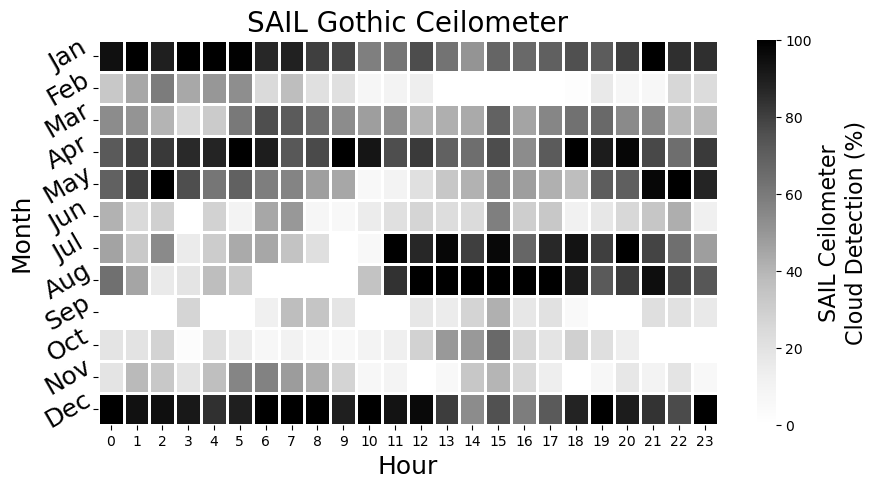

In [97]:
import seaborn as sns
fig, ax=plt.subplots(ncols=1,figsize=(10,5), facecolor='w')

# months = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
sns.heatmap(ceil_df_hourly_cp, cmap='Greys', vmin=0, vmax=100,linewidths=2, cbar_kws={'label':'SAIL Ceilometer\nCloud Detection (%)'}, ax=ax)
# ax.set_xticklabels(ceil_df_hourly.columns, rotation=0, ha='right', size=18);
ax.set_yticklabels(months, rotation=30, ha='center', size=18);
ax.tick_params(axis='y', which='major', pad=18)
ax.set_xlabel('Hour',size=18)
ax.set_ylabel('Month', size=18)
ax.set_title('SAIL Gothic Ceilometer', size=20)
ax.figure.axes[-1].yaxis.label.set_size(16)


In [ ]:
ls_ds = xr.concat([ls_ds_00, ls_ds_01, ls_ds_02, ls_ds_03, ls_ds_04],dim='time')

In [141]:
ls_ds_hourly = add_local_time(ls_ds.sortby('time'))[['local_time','precip_rate','qc_precip_rate']]
ls_df_hourly = ls_ds_hourly.to_dataframe().set_index('local_time')

In [142]:
ls_df_hourly = ls_df_hourly.resample('1H').mean()

In [158]:
# create dataframe for plotting
tmp = []
idx = np.array([1,2,3,4,5,6,7,8,9,10,11,12])

for month in ls_df_hourly.index.month.unique():
    a = ls_df_hourly[(ls_df_hourly.index.month == month) & (ls_df_hourly['qc_precip_rate']==0)]['precip_rate']
    a = a.groupby(a.index.hour).mean()
    a.name=month
    tmp.append(a)
ls_df_hr = pd.concat(tmp, axis=1).T
ls_df_hr = ls_df_hr.sort_index()

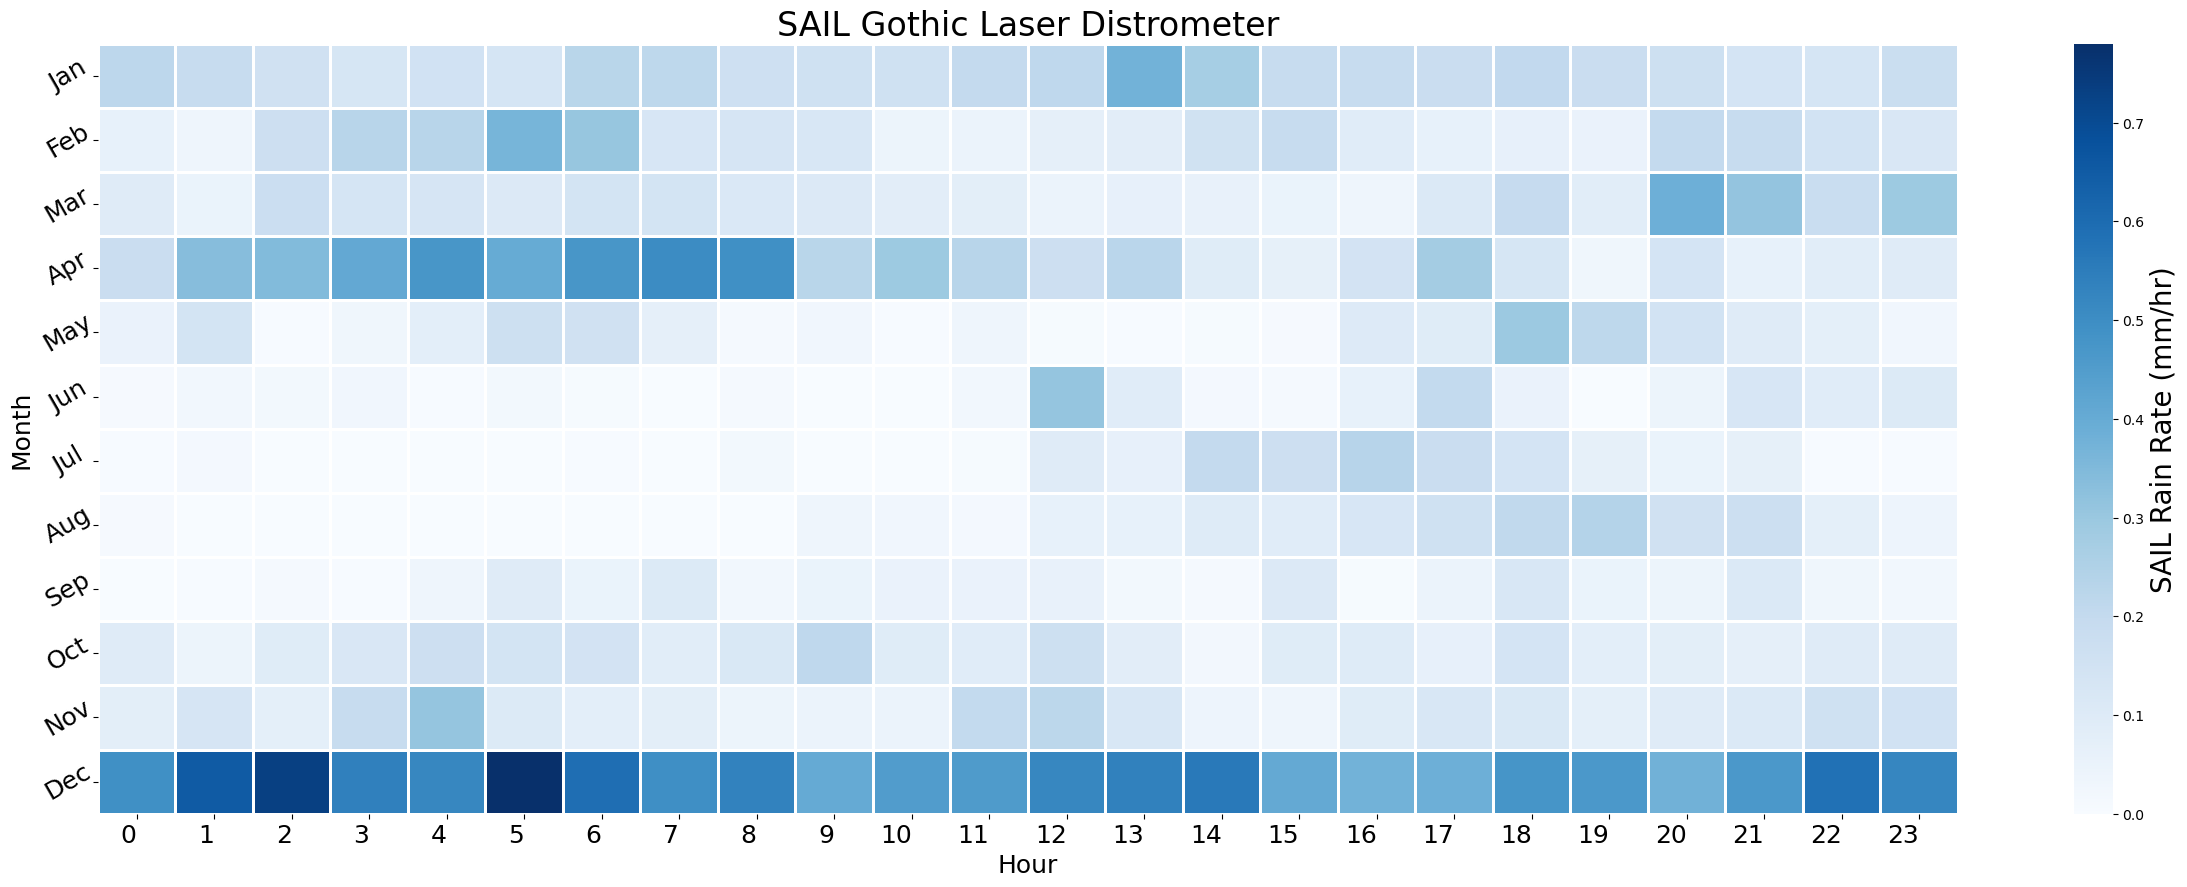

In [159]:
import seaborn as sns

fig, ax=plt.subplots(ncols=1,figsize=(30,10), facecolor='w')

# months = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
sns.heatmap(ls_df_hr, cmap='Blues',linewidths=2,cbar_kws={'label':'SAIL Rain Rate (mm/hr)'}, ax=ax)
ax.set_xticklabels(ls_df_hr.columns, rotation=0, ha='right', size=18);
ax.set_yticklabels(months, rotation=30, ha='center', size=18);
ax.tick_params(axis='y', which='major', pad=18)
ax.set_xlabel('Hour',size=18)
ax.set_ylabel('Month', size=18)
ax.set_title('SAIL Gothic Laser Distrometer', size=24)
ax.figure.axes[-1].yaxis.label.set_size(20)